In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy import signal as ss
from scipy import stats as st
sep = '\\'

In [25]:
def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups


def load_raw_data(kilosort_folder, recording, num_channels):
    path = os.path.join(kilosort_folder, recording, recording) + '.dat'
    temp_data = np.memmap(path, dtype=np.int16)
    adjusted_len = int(len(temp_data) / num_channels)  # adjust for number of channels

    raw_data = np.memmap(path, dtype=np.int16, shape=(adjusted_len, num_channels))
    return raw_data


def choosing_spike(extracted_spikes, time_chosen):
    Spike_chosen = (extracted_spikes - time_chosen * 30000).abs().argsort()[:1]
    return Spike_chosen


def load_data(recording, kilosort_folder, verbose):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(os.path.join(kilosort_folder, recording))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups


def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values


def band_passfilter(fs, low=None, high=None, order=None):
    low = low / (fs / 2)
    high = high / (fs / 2)
    return ss.butter(N=order, Wn=(low, high), btype='pass')


def apply_filter(array, low, high, fs, order, axis=-1):
    b, a = band_passfilter(fs=fs, low=low, high=high, order=order)
    return ss.filtfilt(b, a, array, axis=axis)


def create_trace_parameters(time_span, extracted_spikes, Spike_chosen):
    num_samples_in_trace = time_span * 30000
    waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))
    start_index = int(extracted_spikes.iloc[Spike_chosen] + waveform_window[0])
    end_index = int((extracted_spikes.iloc[Spike_chosen] + waveform_window[-1]) + 1)
    return start_index, end_index


def extract_highlighted_spikes(time_span, extracted_spikes, Spike_chosen):
    num_samples_in_trace = time_span * 30000
    waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))
    start_index = int(extracted_spikes.iloc[Spike_chosen] + waveform_window[0])
    end_index = int((extracted_spikes.iloc[Spike_chosen] + waveform_window[-1]) + 1)
    highlighted_spike_list = extracted_spikes[(start_index <= extracted_spikes) & (extracted_spikes <= end_index)]
    return highlighted_spike_list


def create_3D_matrix(num_spikes_for_averaging, extracted_spikes, data):
    threeD_matrix = np.zeros((num_spikes_for_averaging, 60, 32))
    waveform_window = np.arange(-30, 30)
    for spike in np.arange(0, num_spikes_for_averaging):
        start_index = int(extracted_spikes.iloc[spike] + waveform_window[0])
        end_index = int((extracted_spikes.iloc[spike] + waveform_window[-1]) + 1)

        waveform = data[start_index:end_index, 0:32]
        threeD_matrix[spike, :, :] = waveform[:, :]
    return threeD_matrix


def extract_trace(Spike_chosen, extracted_spikes, time_span, data, chosen_channel):
    start_index, end_index = create_trace_parameters(time_span, extracted_spikes, Spike_chosen)
    filtered_data = apply_filter(array=data[start_index:end_index, chosen_channel], low=400, high=6000, fs=30000, order=4)
    df_trace = pd.DataFrame({'Value': filtered_data})
    df_trace['time'] = np.arange(start_index / 30000, end_index / 30000, 1 / 30000)
    return df_trace


def choose_channel(Spike_chosen, extracted_spikes, time_span, data, broken_chans, num_spikes_for_averaging):
    start_index, end_index = create_trace_parameters(time_span, extracted_spikes, Spike_chosen)
    temporary_df = pd.DataFrame(data[start_index:end_index])
    if broken_chans:
        for chan in broken_chans:
            temporary_df.drop((chan), inplace=True, axis=1)

    threeD_matrix = create_3D_matrix(num_spikes_for_averaging, extracted_spikes, data)

    mean_waveform = np.mean(threeD_matrix, axis=0)
    waveform_per_channel_df = pd.DataFrame(mean_waveform)
    maxes = waveform_per_channel_df.apply(np.min, axis=0)
    chosen_channel = maxes.idxmin()
    return chosen_channel


def spike_highlight(spike, extracted_spikes, data, chosen_channel):
    window_for_highlight = np.arange(-30, 30)
    start_highlight = int(spike + window_for_highlight[0])
    end_highlight = int((spike + window_for_highlight[-1]) + 1)
    filtered_highlight_data = apply_filter(array=data[start_highlight:end_highlight, chosen_channel], low=400, high=6000, fs=30000, order=4)
    df_highlight = pd.DataFrame({'Value': filtered_highlight_data})
    df_highlight['time'] = np.arange(start_highlight, end_highlight, 1)
    df_highlight_final = pd.DataFrame({'time': df_highlight['time'] / 30000, 'Value': df_highlight['Value']})
    return df_highlight_final


def plot_final_data(kilosort_folder, recording, chosen_channel, chosen_cluster, highlighted_spike_list, time_chosen):
    fig_folder =  os.path.join(kilosort_folder, recording, 'figures', 'Cluster no.' + str(chosen_cluster))
    plt.ylim(-2000, 2000)
    plt.tick_params(axis='both', which='major', labelsize=20)
    #plt.xlabel('time (s)', fontsize=28)
    #plt.ylabel('amplitude', fontsize=28)
    #plt.title('Recording: {0} \n Channel: {1} \n Cluster: {2}' .format(recording, chosen_channel, chosen_cluster), fontsize=28)
    #plt.annotate('no. of spikes: {}'.format(len(highlighted_spike_list)), xy=(time_chosen, 1500), xytext=(time_chosen, 1500), size=30)
    mkdirs_(fig_folder)
    plt.tight_layout()
    if time_chosen >= 60*60: 
        figpath = os.path.join(kilosort_folder, recording, 'figures', 'Cluster no.' + str(chosen_cluster), recording + ' Cluster no.' + str(chosen_cluster) + ' After.png')
    else:
        figpath = os.path.join(kilosort_folder, recording, 'figures', 'Cluster no.' + str(chosen_cluster), recording + ' Cluster no.' + str(chosen_cluster) + ' Before.png')
    plt.savefig(figpath)


def choose_cluster_to_plot(cluster_groups, spike_clusters, spike_times, chosen_cluster):
    good_cluster_numbers = get_good_cluster_numbers(cluster_groups)
    df = pd.DataFrame({'cluster': spike_clusters.flatten(), 'spike_times': spike_times.flatten()})
    df = df.loc[df['cluster'].isin(good_cluster_numbers)]
    cluster_to_plot = good_cluster_numbers[good_cluster_numbers == chosen_cluster][0]
    return df, cluster_to_plot

def mkdirs_(path):
    if not os.path.exists(path):
        os.mkdir(path)


In [38]:
kilosort_folder = r'F:\CIT_WAY'
recording = '2018-05-01_01'
num_channels = 32
chosen_cluster = 0
time_chosen = 3000
time_span = 1
broken_chans = [22]
num_spikes_for_averaging = 3000
color = 'b'
verbose = True 


Loading Data:	2018-05-01_01

0
16

0
24

0
26

0
31

0
33

0
71

0
83

1
16

1
24

1
26

1
31

1
33

1
71

1
83

2
16

2
24

2
26

2
31

2
33

2
71

2
83

3
16

3
24

3
26

3
31

3
33

3
71

3
83

4
16

4
24

4
26

4
31

4
33

4
71

4
83

5
16

5
24

5
26

5
31

5
33

5
71

5
83

6
16

6
24

6
26

6
31

6
33

6
71

6
83

7
16

7
24

7
26

7
31

7
33

7
71

7
83

8
16

8
24

8
26

8
31

8
33

8
71

8
83

9
16

9
24

9
26

9
31

9
33

9
71

9
83

10
16

10
24

10
26

10
31

10
33

10
71

10
83

11
16

11
24

11
26

11
31

11
33

11
71

11
83

12
16

12
24

12
26

12
31

12
33

12
71

12
83

13
16

13
24

13
26

13
31

13
33

13
71

13
83

14
16

14
24

14
26

14
31

14
33

14
71

14
83

15
16

15
24

15
26

15
31

15
33

15
71

15
83

16
16

16
24

16
26

16
31

16
33

16
71

16
83

17
16

17
24

17
26

17
31

17
33

17
71

17
83

18
16

18
24

18
26

18
31

18
33

18
71

18
83

19
16

19
24

19
26

19
31

19
33

19
71

19
83

20
16

20
24

20
26

20
31

20
33

20
71

20
83

21
16

21
2

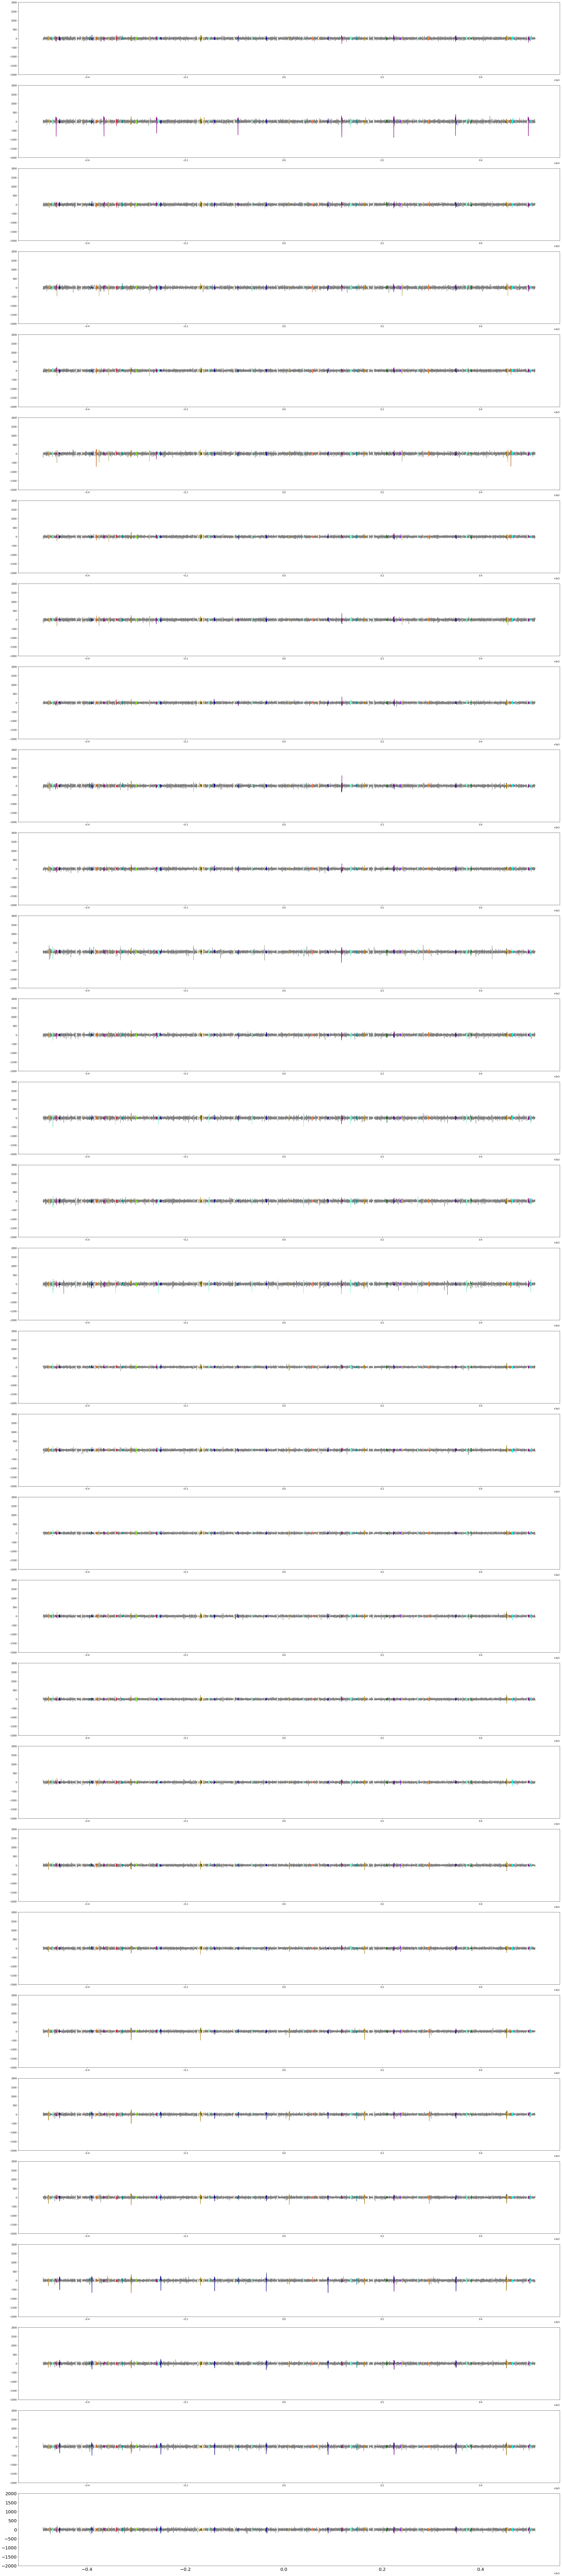

In [39]:
data = load_raw_data(kilosort_folder=kilosort_folder,
                         recording=recording,
                         num_channels=num_channels)
spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                            kilosort_folder=kilosort_folder,
                                                            verbose=verbose)
df, cluster_to_plot = choose_cluster_to_plot(cluster_groups=cluster_groups,
                                                 spike_clusters=spike_clusters,
                                                 spike_times=spike_times,
                                                 chosen_cluster=chosen_cluster)

#extracted_spikes = df[df['cluster'] == cluster_to_plot]['spike_times']
Spike_chosen = choosing_spike(extracted_spikes=df['spike_times'],
                                  time_chosen=time_chosen)

start_index, end_index = create_trace_parameters(time_span=time_span, extracted_spikes=df['spike_times'], Spike_chosen=Spike_chosen)

f, a = plt.subplots(32-len(broken_chans), 1, sharey=True, figsize=(35, 160))


for channel in np.arange(0, 32 - len(broken_chans)):
    
    df_trace = extract_trace(Spike_chosen=Spike_chosen, extracted_spikes=df['spike_times'], time_span=time_span, data=data, chosen_channel=channel)

    a[channel].plot(df_trace['time'], df_trace['Value'], color='gray')


    good_cluster_numbers = get_good_cluster_numbers(cluster_groups)

    num_samples_in_trace = time_span * 30000
    waveform_window = np.arange(int(-num_samples_in_trace / 2), int(num_samples_in_trace / 2))    
    start_index = int(df['spike_times'].iloc[Spike_chosen] + waveform_window[0])
    end_index = int((df['spike_times'].iloc[Spike_chosen] + waveform_window[-1]) + 1)


    for ind, cluster in enumerate(good_cluster_numbers):
        new_extracted_spikes = df[df['cluster'] == cluster]['spike_times']
        highlighted_spike_list = new_extracted_spikes[(start_index <= new_extracted_spikes) & (new_extracted_spikes <= end_index)]
        if len(highlighted_spike_list)==0:
            print(channel)
            print(cluster)
            print()
        else:
            for spike in highlighted_spike_list:  # loop over each spike in original trace. Plot in color
                df_highlight = spike_highlight(spike=spike,
                                                   extracted_spikes=new_extracted_spikes,
                                                   data=data,
                                                   chosen_channel=channel)
                a[channel].plot(df_highlight['time'], df_highlight['Value'], color=colorlist[ind])

plot_final_data(kilosort_folder=kilosort_folder, recording=recording, chosen_channel=channel, chosen_cluster=chosen_cluster, highlighted_spike_list = highlighted_spike_list, time_chosen=time_chosen)


In [7]:
import matplotlib
colorlist = []
for name, hex in matplotlib.colors.cnames.items():
    colorlist.append(name)

In [8]:
colorlist[2]

'aqua'

## Todo
    - Take max of each column
    - Take min of each column
    - Take absolute value of the min and max per column
    - Find column that has the highest distance
    - Plot that column

In [ ]:
maxes = waveform_per_channel_df.apply(np.max, axis=0)

In [ ]:
lab = maxes.idxmax()

In [ ]:
maxes.idxmax()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
correct_chan = test_df.loc[:, 'Chan_4']
plt.figure(figsize = (25,1))
correct_chan.plot()
plt.show()

In [ ]:
correct_chan = correct_chan.reset_index()
correct_chan.columns = ['figure', 'y_values']
correct_chan.set_index('figure', inplace=True)

## Calculate half spike width
    - Convert x axis from samples to seconds or ms
    - Find the peak y value, store the x value (time) as a variable
    - Write an algorythm that detect when the y value stops decreases with decreasing x values
    - Return the x value at which this occurs
    - Calculate the distance in time between these points

In [ ]:
max_peak_time = correct_chan.idxmax()[0]
min_peak_time = correct_chan.idxmin()[0]
print(min_peak_time)

In [ ]:
correct_chan.loc[min_peak_time:60].idxmax()[0]

In [ ]:
reverse_counter = np.arange(max_peak_time, -1 ,-1)

counter = np.arange(max_peak_time, 60, 1)

from_min_to_second_max = np.arange(min_peak_time, correct_chan.loc[min_peak_time:60].idxmax()[0], 1)

from_second_max_to_end = np.arange(correct_chan.loc[min_peak_time:60].idxmax()[0], 60, 1)


In [ ]:
from_min_to_second_max

In [ ]:
baseline = []
return_point = []
second_max = []
last_point = []

time_list_2 = []

for reverse_time_point in reverse_counter:
    if correct_chan.loc[reverse_time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        baseline.append(reverse_time_point)
    else:
        pass

for time_point in counter:
    if correct_chan.loc[time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        time_list_2.append(time_point)
    else:
        pass

for return_time_point in from_min_to_second_max:
    if np.absolute(np.absolute(correct_chan.loc[return_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/2):
        return_point.append(return_time_point)
    else:
        pass

for last_time_point in from_second_max_to_end:
    if np.absolute(np.absolute(correct_chan.loc[last_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/10):
        last_point.append(last_time_point)
    else:
        pass

In [ ]:
plt.plot(correct_chan, linestyle=None, marker='.')
plt.plot(np.ones(5)*baseline[-1], np.linspace(-400, 650, 5), 'k')
#plt.plot(np.ones(5)*max_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*last_point[-1], np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')

In [ ]:
print(correct_chan.loc[32][0])
print(correct_chan.loc[33][0])

gradient = []

## Calculate the full spike wide (to troff)
    - Find the minimum value
    - x value
    - calculate the diffference in time between the baseline and the mimum point

In [ ]:
print(min_peak_time)
print(max_peak_time)
print(correct_chan.loc[max_peak_time][0])
print(correct_chan.loc[min_peak_time][0])

Base